In [13]:
import torch
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import plotnine as gg
from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
import seaborn as sns
import tree
from data import rosetta_data_loader

import sys
import argparse
import re
import logging

import pandas as pd
pd.set_option('display.max_colwidth', None)

from omegaconf import DictConfig, OmegaConf
import importlib

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

torch.hub.set_dir('/data/rsg/chemistry/jyim/.cache/torch')
plt.rcParams.update({'font.size': 14})

In [14]:
# Paths
base_dir = '/data/rsg/chemistry/jyim/paper/protdiff_icml/noise_levels'
samples_dir = os.path.join(base_dir, 'samples')
sample_cluster_dir = os.path.join(base_dir, 'sample_clustering')
figure_dir = os.path.join(base_dir, 'figures')
train_align_dir = os.path.join(base_dir, 'train_align')
train_pdbs_dir = os.path.join(base_dir, 'training_pdbs')


base_protdiff_dir = '/data/rsg/chemistry/jyim/projects/protein_diffusion/'

os.makedirs(base_dir, exist_ok=True)
os.makedirs(train_align_dir, exist_ok=True)
os.makedirs(figure_dir, exist_ok=True)
os.makedirs(train_pdbs_dir, exist_ok=True)
os.makedirs(samples_dir, exist_ok=True)
os.makedirs(sample_cluster_dir, exist_ok=True)



if len(os.listdir(base_dir)):
    print('WARNING: overwriting results!')

In [15]:
def read_samples(path):
    
    def process_path(x):
        length_path = os.path.join(*x.split('/')[-5:])
        return os.path.join(path, length_path)
    
    all_csvs = []
    # results_dir = '/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/saved_run_2'
    print(f'Reading samples from {path}')
    for sample_length in os.listdir(path):
        if '.' in sample_length:
            continue
        length_dir = os.path.join(path, sample_length)
        for i,sample_name in enumerate(os.listdir(length_dir)):
            if '.' in sample_name:
                continue
            csv_path = os.path.join(length_dir, sample_name, 'mpnn', 'sc_results.csv')
            sample_id = int(sample_name.split('_')[1])
            if os.path.exists(csv_path):
                design_csv = pd.read_csv(csv_path, index_col=0)
                length = int(sample_length.split('_')[1])
                design_csv['length'] = length
                design_csv['sequence_id'] = design_csv['sample_path'].apply(lambda x: int(os.path.basename(x).replace('.pdb', '').split('_')[1]))
                design_csv['esmf_path'] = design_csv['sample_path'].apply(process_path)
                del design_csv['sample_path']
                design_csv['sample_id'] = sample_id
                design_csv['backbone_path'] = os.path.join(path, f'length_{length}', f'sample_{sample_id}', 'sde_1.pdb')
                all_csvs.append(design_csv)
    return pd.concat(all_csvs)


In [35]:
# noise_dir = lambda x: f'/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/continue_0/05D_01M_2023Y_21h_15m_16s/unconditional/noise_level_{x}'
noise_dir = lambda x: f'/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_{x}'
samples_noise_00 = read_samples(noise_dir('00'))
samples_noise_01 = read_samples(noise_dir('01'))
samples_noise_05 = read_samples(noise_dir('05'))
samples_noise_10 = read_samples(noise_dir('10'))


Reading samples from /data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_00
Reading samples from /data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01
Reading samples from /data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_05
Reading samples from /data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_10


In [36]:
samples_noise_00['Noise scale'] = '0.0'
samples_noise_01['Noise scale'] = '0.1'
samples_noise_05['Noise scale'] = '0.5'
samples_noise_10['Noise scale'] = '1.0'

samples_all_noise = pd.concat([
    samples_noise_00,
    samples_noise_01,
    samples_noise_05,
    samples_noise_10
])
samples_all_noise['Noise scale'] = pd.Categorical(
    samples_all_noise['Noise scale'], ordered=True, categories=['0.0', '0.1', '0.5', '1.0'])

# Process results

In [24]:
length_categories = [
    '100-200', '200-300', '300-400', '400-500'
]
buckets = np.arange(200, 501, 100)
buckets[-1] += 1

def df_process(raw_df):
    # Process sample path
    df = raw_df.copy()
    
    # Separate based on whether MPNNed
    df['header'] = df['header'].fillna('')
    df = df[df['header'].map(lambda x: 'sde_1' not in x)]
    return df

def sc_filter(raw_df, metric):
    # Pick best self-consistency sample
    if metric == 'rmsd':
        df = raw_df.sort_values('rmsd', ascending=True)
    elif metric == 'tm':
        df = raw_df.sort_values('tm_score', ascending=False)
    else:
        raise ValueError(f'Unrecognized metric: {metric}')
    df = df.groupby(['length', 'sample_id']).first().reset_index()

    # Separate into different length groups
    df['length_group'] = df.length.map(lambda x: length_categories[np.sum(x > buckets).item()])
    df['length_group'] = pd.Categorical(df['length_group'], ordered=True, categories=length_categories)

    # Calculate how designable
    cutoff = 0.5
    if metric == 'rmsd':
        df['designable'] = df.rmsd.map(lambda x: x < 2.0)
    elif metric == 'tm':
        df['designable'] = df.tm_score.map(lambda x: x > 0.5)
    designable_df = pd.pivot_table(df, values='designable', index='length_group', aggfunc=np.mean).reset_index()
    percent_designable = df['designable'].mean()
    print(f'Percent designable: {percent_designable}')
    print(f'Average scRMSD: {df.rmsd.mean()}')
    return df, designable_df


def process_pipeline(raw_df, metric):
    processed_df = df_process(raw_df)
    seq_8_df = processed_df[(processed_df.sequence_id < 8) & (processed_df.length >= 100) & (processed_df.length <= 500)]
    df, designable = sc_filter(seq_8_df, metric=metric)
    return df, designable


In [25]:
plt.rcParams.update({'font.size': 14})

def plot_sc_rmsd(df, save_path=None):
    rmsd_samples, _ = process_pipeline(df, metric='rmsd')
    
    p = sns.boxplot(
        data=rmsd_samples,
        x='length_group',
        y='rmsd',
        hue='Noise scale',
        showfliers = False
    )

    plt.xlabel('Length group')
    plt.ylabel('scRMSD')
    legend = plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0)
    p.legend_.set_title('Noise \nscale')
    plt.ylim(0.0, 25)
    if save_path is None:
        plt.show()
    else:
        # fig_path = os.path.join(figure_dir, 'unconditional_scrmsd_plt.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
def plot_sc_tm(df, save_path=None):
    tm_samples, tm_designable = process_pipeline(df, metric='tm')

    p = sns.boxplot(
        data=tm_samples,
        x='length_group',
        y='tm_score',
        hue='Noise scale',
        showfliers = False
    )

    designable_numbers = tm_designable[tm_designable.Sequences == 8].designable.tolist()
    for i,xtick in enumerate(p.get_xticks()):
        p.text(
            xtick,
            1.0,
            f"{designable_numbers[i]*100:2.1f}%\n",
            horizontalalignment='center',
            size='small',
            color='blue',
            weight='semibold'
        )

    designable_numbers = tm_designable[tm_designable.Sequences == 100].designable.tolist()
    for i,xtick in enumerate(p.get_xticks()):
        p.text(
            xtick,
            0.95,
            f"{designable_numbers[i]*100:2.1f}%\n",
            horizontalalignment='center',
            size='small',
            color='orange',
            weight='semibold'
        )

    plt.axhline(y = 0.5, color = 'r', linestyle = '--', linewidth=2, alpha=0.5)
    plt.ylim(0.0, 1.1)
    plt.xlabel('Length group')
    plt.ylabel('scTM')

    legend = plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0)
    p.legend_.set_title('Noise \nscale')

    if save_path is None:
        plt.show()
    else:
        # fig_path = os.path.join(figure_dir, 'unconditional_scrmsd_plt.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')


# Plot designable results

In [31]:
sampels_100_steps = read_samples('/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_steps_100')


Reading samples from /data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_steps_100


In [34]:
_ = process_pipeline(sampels_100_steps, metric='tm')
_ = process_pipeline(sampels_100_steps, metric='rmsd')

Percent designable: 0.7434944237918215
Average scRMSD: 7.6601894204740715
Percent designable: 0.2503097893432466
Average scRMSD: 7.162854626677831


In [38]:
noise_10_df, _ = process_pipeline(samples_noise_10, metric='tm')
noise_05_df, _ = process_pipeline(samples_noise_05, metric='tm')
noise_01_df, _ = process_pipeline(samples_noise_01, metric='tm')
noise_00_df, _ = process_pipeline(samples_noise_00, metric='tm')

Percent designable: 0.48641975308641977
Average scRMSD: 11.174208670282999
Percent designable: 0.7419753086419754
Average scRMSD: 7.775677000246971
Percent designable: 0.7493827160493827
Average scRMSD: 7.481608175750787
Percent designable: 0.7444444444444445
Average scRMSD: 7.388139974678661


In [37]:
noise_10_df, _ = process_pipeline(samples_noise_10, metric='rmsd')
noise_05_df, _ = process_pipeline(samples_noise_05, metric='rmsd')
noise_01_df, _ = process_pipeline(samples_noise_01, metric='rmsd')
noise_00_df, _ = process_pipeline(samples_noise_00, metric='rmsd')

Percent designable: 0.11358024691358025
Average scRMSD: 10.352043927092334
Percent designable: 0.23209876543209876
Average scRMSD: 7.156512998707662
Percent designable: 0.27901234567901234
Average scRMSD: 6.926751980001301
Percent designable: 0.3074074074074074
Average scRMSD: 6.939163342096009


Percent designable: 0.9179292929292929
Average scRMSD: 3.8851308359718275


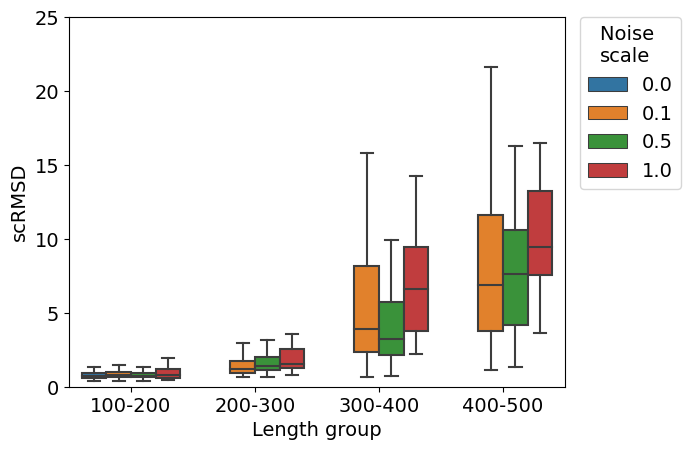

In [22]:
plot_sc_rmsd(samples_all_noise, save_path='scrmsd_noise.png')

Percent designable: 0.9381313131313131
Average scRMSD: 4.151296951706286


AttributeError: 'DataFrame' object has no attribute 'Sequences'

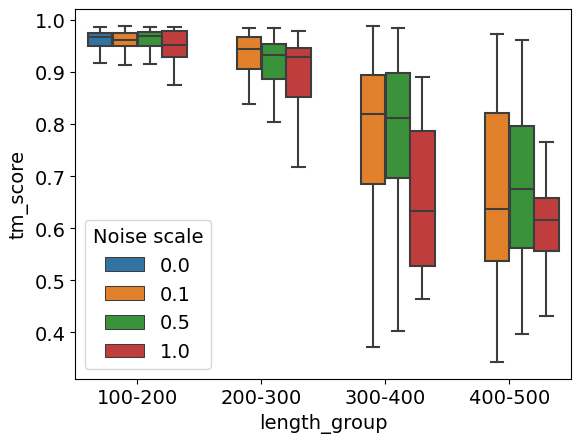

In [23]:
plot_sc_tm(samples_all_noise, save_path='sctm_noise.png')

In [ ]:
rmsd_samples, _ = process_pipeline(samples_all_noise, metric='rmsd')

p = sns.boxplot(
    data=rmsd_samples,
    # x='length_group',
    x='Noise scale',
    y='rmsd',
    # hue='Noise scale',
    showfliers = False
)

# Save samples

In [30]:
for noise_scale in ['00', '01', '05', '10']:
    print(f'On {noise_scale}')
    sample_dir = f'/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_{noise_scale}'
    base_dir = f'/data/rsg/chemistry/jyim/paper/protdiff_icml/noise_scale_{noise_scale}_results'
    designed_samples_dir = os.path.join(base_dir, 'designed_samples')
    designed_samples_cluster_dir = os.path.join(base_dir, 'designed_samples_clustering')

    if os.path.exists(designed_samples_dir):
        shutil.rmtree(designed_samples_dir)
    if os.path.exists(designed_samples_cluster_dir):
        shutil.rmtree(designed_samples_cluster_dir)

    os.makedirs(designed_samples_dir, exist_ok=False)
    os.makedirs(designed_samples_cluster_dir, exist_ok=False)
    fname = os.path.join(designed_samples_dir, 'sc_pdbs.txt')
    
    with open(fname, 'w') as f:
        for sample_length in os.listdir(sample_dir):
            if '.' in sample_length:
                continue
            length_dir = os.path.join(sample_dir, sample_length)
            length = sample_length.split('_')[1]
            for sample_name in os.listdir(length_dir):
                if '.' in sample_name:
                    continue
                sample_path = os.path.join(length_dir, sample_name, 'sde_1.pdb')
                sample_id = sample_name.split('_')[1]
                save_path = os.path.join(designed_samples_dir, f'length_{length}_id_{sample_id}.pdb')
                shutil.copy(sample_path, save_path)
                f.write(save_path+'\n')
    print(
        f'./maxcluster64bit -l {fname} -C 2 -in -Rl {designed_samples_cluster_dir}/all_by_all_lite \-TM -Tm 0.5 > {designed_samples_cluster_dir}/maxcluster_results.txt'
    )

On 00
./maxcluster64bit -l /data/rsg/chemistry/jyim/paper/protdiff_icml/noise_scale_00_results/designed_samples/sc_pdbs.txt -C 2 -in -Rl /data/rsg/chemistry/jyim/paper/protdiff_icml/noise_scale_00_results/designed_samples_clustering/all_by_all_lite \-TM -Tm 0.5 > /data/rsg/chemistry/jyim/paper/protdiff_icml/noise_scale_00_results/designed_samples_clustering/maxcluster_results.txt
On 01
./maxcluster64bit -l /data/rsg/chemistry/jyim/paper/protdiff_icml/noise_scale_01_results/designed_samples/sc_pdbs.txt -C 2 -in -Rl /data/rsg/chemistry/jyim/paper/protdiff_icml/noise_scale_01_results/designed_samples_clustering/all_by_all_lite \-TM -Tm 0.5 > /data/rsg/chemistry/jyim/paper/protdiff_icml/noise_scale_01_results/designed_samples_clustering/maxcluster_results.txt
On 05
./maxcluster64bit -l /data/rsg/chemistry/jyim/paper/protdiff_icml/noise_scale_05_results/designed_samples/sc_pdbs.txt -C 2 -in -Rl /data/rsg/chemistry/jyim/paper/protdiff_icml/noise_scale_05_results/designed_samples_clustering/a

# Read cluster outputs

In [5]:
import os
import pandas as pd

In [13]:
with open('/data/rsg/chemistry/jyim/paper/protdiff_icml/noise_level_01_steps_100_results/designed_samples_clustering/maxcluster_results.txt', 'r') as f:
    capture = False
    centroid_lines = []
    for line in f.read().splitlines():
        if capture:
            centroid_lines.append(line)
        if 'INFO  : Cluster  Centroid  Size        Spread' in line:
            capture = True
            
centroid_lines = centroid_lines[:-1]

data = {'Cluster size': [], 'path': [], 'length': [], 'sample_id': []} #, 'tm_v_pdb100': []}
for line in centroid_lines:
    line = line.split()
    cluster_size = line[5]
    path = line[7]
    filename = os.path.basename(path).replace('.pdb', '')
    data['Cluster size'].append(int(cluster_size))
    data['path'].append(path)
    data['length'].append(int(filename.split('_')[1]))
    data['sample_id'].append(int(filename.split('_')[3]))

clusters_df = pd.DataFrame(data)

In [14]:
clusters_df.shape

(487, 4)

In [16]:
487/890

0.547191011235955

In [11]:
with open('/data/rsg/chemistry/jyim/paper/protdiff_icml/noise_level_01_seqs_100_results/designed_samples_clustering/maxcluster_results.txt', 'r') as f:
    capture = False
    centroid_lines = []
    for line in f.read().splitlines():
        if capture:
            centroid_lines.append(line)
        if 'INFO  : Cluster  Centroid  Size        Spread' in line:
            capture = True
            
centroid_lines = centroid_lines[:-1]

data = {'Cluster size': [], 'path': [], 'length': [], 'sample_id': []} #, 'tm_v_pdb100': []}
for line in centroid_lines:
    line = line.split()
    cluster_size = line[5]
    path = line[7]
    filename = os.path.basename(path).replace('.pdb', '')
    data['Cluster size'].append(int(cluster_size))
    data['path'].append(path)
    data['length'].append(int(filename.split('_')[1]))
    data['sample_id'].append(int(filename.split('_')[3]))

clusters_df = pd.DataFrame(data)

In [12]:
clusters_df.shape

(484, 4)